Conclusion:
- The stldecompose package assigns more variations of the time series to the residual part than the statsmodels.tra module. Therefore it's easier to detect the anomalies using the stldecompose package.
- To apply STL decomposition, we need at least data in 12 consecutive months.


Questions/To-Do's:
- how to systematically detect outliers in residuals for each ts? - For Loop over all meters with enough months of data
- what about series with lots of missing data? Ignore for now
- cases where all imputed kwh is zero - account '102.0 - MORRIS I BLD 05_1096662 41.5'
- The Python package of Twitter Anomaly Detection algorithm is incorrect. Need to modify the seasonal_esd function; also it only returns anomaly indices, not the residual/seasonality components; seems can't detect the first anomaly in the 2nd example of account "164.0 - BLD 01_96973681"
- STL decomposition can't detect level changes (I tested this with fake level change) - How to detect the "level changes" in all accounts?

## Import modules and the dataset

In [101]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose

from matplotlib import pyplot
import matplotlib.pylab as plt
# the main library has a small set of functionality
from stldecompose import decompose, forecast
from stldecompose.forecast_funcs import (naive,
                                         drift, 
                                         mean, 
                                         seasonal_naive)
import sesd

In [102]:
from PyAstronomy import pyasl

In [103]:
df = pd.read_pickle("../output/NYCHA_Electricity_2010_to_2018_df_prorated_kwh_imputed")

## Find the accounts with smalll amount of missing data

In [4]:
max(df.Month)

Timestamp('2018-06-01 00:00:00')

In [5]:
mask = df['Month'] >= '2012-06-01 00:00:00'

In [6]:
df_back = df.copy()

In [7]:
df = df[mask]

In [8]:
df_account_type = \
pd.merge(df.groupby('Building_Meter').agg({'Month':'count'}).reset_index(), \
df[df['Gap_Type'] != 'Full Month Gap'].groupby('Building_Meter').agg({'Month':'count'}).reset_index(), \
on = 'Building_Meter', how = 'inner')

df_account_type.columns = ['Building_Meter', 'Months_Total', 'Months_With_Data']

df_account_type['Perc_Months_With_Data'] = df_account_type['Months_With_Data'] / df_account_type['Months_Total']

1,119 accounts have no missing data in the last 6 years.

In [9]:
df_account_type['Perc_Months_With_Data'].value_counts().sort_index(ascending = False)

1.000000    1119
0.986301     182
0.986111      19
0.985915      16
0.985714      43
0.985507       2
0.985294       4
0.985075       6
0.984848       1
0.984615       2
0.984375       1
0.983607       2
0.983051      13
0.982759       2
0.982456       1
0.980769       2
0.980392       2
0.979592       2
0.978723       1
0.977778       1
0.976744       4
0.976190       3
0.975610       1
0.972973       1
0.972603      85
0.972222      18
0.971831      41
0.971429      10
0.971014       2
0.970149       3
            ... 
0.461538       2
0.458333       7
0.454545       6
0.450000       1
0.448276       1
0.444444       1
0.428571       2
0.416667       4
0.411765       1
0.409091       2
0.400000       6
0.387097       1
0.375000       4
0.363636       8
0.354839       3
0.350000       4
0.333333       6
0.323529       2
0.322581       4
0.300000       8
0.290323       2
0.285714       4
0.264706       1
0.259259       1
0.258065       4
0.250000       4
0.230769       1
0.222222      

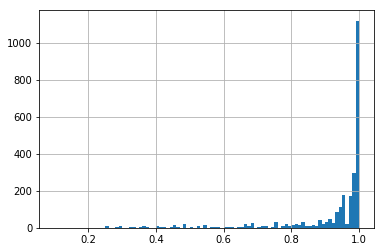

In [10]:
df_account_type['Perc_Months_With_Data'].hist(bins = 90)

In [11]:
df_account_type.head()

,Building_Meter,Months_Total,Months_With_Data,Perc_Months_With_Data
0,1.0 - BLD 01_7836716,73,60,0.821918
1,1.0 - BLD 01_7838586,73,60,0.821918
2,1.0 - BLD 02_7694040,73,60,0.821918
3,1.0 - BLD 03_7177432,73,59,0.808219
4,1.0 - BLD 04_7381828,73,60,0.821918


In [12]:
df_account_type[df_account_type['Months_Total'] == 73][['Perc_Months_With_Data']].describe().loc[['mean', 'std']]

,Perc_Months_With_Data
mean,0.974068
std,0.047920


Focus on accounts that should have data in the most recent 6 years and % of missing months is low.

In [13]:
df = df_back.copy()

In [14]:
mask = df_back['Building_Meter'].isin(\
df_account_type[(df_account_type['Months_Total'] == 73) & (df_account_type['Perc_Months_With_Data'] > 0.974068 - 0.047920)].Building_Meter.values)

There are 941 such accounts in total.

In [15]:
df = df_back[mask]

In [16]:
df.Building_Meter.nunique()

941

In [17]:
df.head()

,Building_Meter,Month,Month_Type,Month_#_Days,Prorated_Days,Gap_Days,Gap_Type,Prorated_KWH,Imputed_KWH
0,165.0 - BLD 04_99273488,2009-12-01,First_Month,31,9.0,0.0,No Gap,19694.117647,67835.294118
1,165.0 - BLD 04_99273488,2010-01-01,Month_In_The_Middle,31,31.0,0.0,No Gap,68283.025210,68283.025210
2,165.0 - BLD 04_99273488,2010-02-01,Month_In_The_Middle,28,28.0,0.0,No Gap,61071.133005,61071.133005
3,165.0 - BLD 04_99273488,2010-03-01,Month_In_The_Middle,31,31.0,0.0,No Gap,58011.118077,58011.118077
4,165.0 - BLD 04_99273488,2010-04-01,Month_In_The_Middle,30,30.0,0.0,No Gap,55164.054336,55164.054336


In [104]:
df.to_csv("/Users/feiwang/Desktop/working/r/NYCHA_TS.csv")

In [110]:
df_interpolate = df.interpolate(method='time')

In [111]:
mask = df_interpolate['Building_Meter'] == '1.0 - BLD 01_7836716'
df_interpolate[mask]

,Building_Meter,Month,Month_Type,Month_#_Days,Prorated_Days,Gap_Days,Gap_Type,Prorated_KWH,Imputed_KWH
122895,1.0 - BLD 01_7836716,2009-12-01,First_Month,31,8.0,0.0,No Gap,212.363636,822.909091
122896,1.0 - BLD 01_7836716,2010-01-01,Month_In_The_Middle,31,31.0,0.0,No Gap,805.236364,805.236364
122897,1.0 - BLD 01_7836716,2010-02-01,Month_In_The_Middle,28,28.0,0.0,No Gap,680.606897,680.606897
122898,1.0 - BLD 01_7836716,2010-03-01,Month_In_The_Middle,31,31.0,0.0,No Gap,853.147942,853.147942
122899,1.0 - BLD 01_7836716,2010-04-01,Month_In_The_Middle,30,30.0,0.0,No Gap,715.645161,715.645161
122900,1.0 - BLD 01_7836716,2010-05-01,Month_In_The_Middle,31,31.0,0.0,No Gap,809.800000,809.800000
122901,1.0 - BLD 01_7836716,2010-06-01,Month_In_The_Middle,30,30.0,0.0,No Gap,698.400000,698.400000
122902,1.0 - BLD 01_7836716,2010-07-01,Month_In_The_Middle,31,31.0,0.0,No Gap,708.800000,708.800000
122903,1.0 - BLD 01_7836716,2010-08-01,Month_In_The_Middle,31,31.0,0.0,No Gap,780.000000,780.000000
122904,1.0 - BLD 01_7836716,2010-09-01,Month_In_The_Middle,30,30.0,0.0,No Gap,847.200000,847.200000


## Time Series decomposition

### seasonal_decompose package

Exampe 1 - No gap month

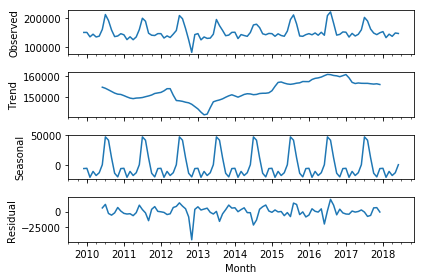

In [22]:
mask = df.Building_Meter == '165.0 - BLD 03_90327795'
series = df.loc[mask, ['Month', 'Imputed_KWH']].set_index('Month')

result = seasonal_decompose(series, model='additive')

series = pd.concat([series, result.trend, result.seasonal, result.resid], axis = 1).reset_index()
series.columns = ['Month', 'Observed', 'Trend', 'Seasonal', 'Residual']
series['Seasonally_Adjusted'] = series.apply(lambda x: x['Observed'] - x['Seasonal'], axis = 1)

# Meter with all the months' data. Outlier near Sep 2012

result.plot()
pyplot.show()
result1 = result

Exampel 2 - A few months's gap in between. Otherwise the variations seem normal.

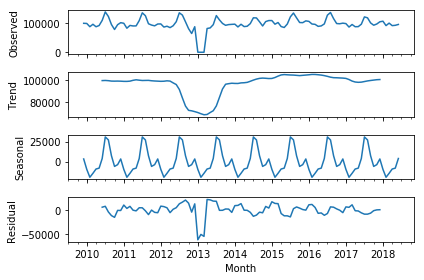

In [39]:
mask = df.Building_Meter == '164.0 - BLD 01_96973681'
series = df.loc[mask, ['Month', 'Imputed_KWH']].set_index('Month')

result = seasonal_decompose(series, model='additive')

series = pd.concat([series, result.trend, result.seasonal, result.resid], axis = 1).reset_index()
series.columns = ['Month', 'Observed', 'Trend', 'Seasonal', 'Residual']
series['Seasonally_Adjusted'] = series.apply(lambda x: x['Observed'] - x['Seasonal'], axis = 1)

result.plot()
pyplot.show()
result2 = result

Example 3 - Number of months is too small - only 12

In [24]:
mask = df.Building_Meter == '1.0 - BLD 04_8638820'
series = df.loc[mask, ['Month', 'Imputed_KWH']].set_index('Month')
series.plot()

result = seasonal_decompose(series, model='additive')

series = pd.concat([series, result.trend, result.seasonal, result.resid], axis = 1).reset_index()
series.columns = ['Month', 'Observed', 'Trend', 'Seasonal', 'Residual']
series['Seasonally_Adjusted'] = series.apply(lambda x: x['Observed'] - x['Seasonal'], axis = 1)

result.plot()
pyplot.show()
result3 = result

TypeError: Empty 'DataFrame': no numeric data to plot

### stldecompose package

Exampel 1

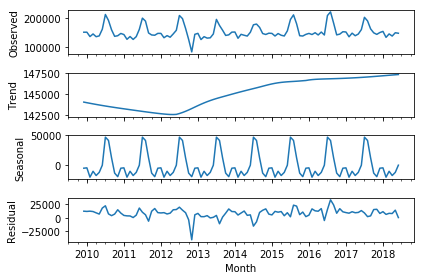

In [67]:
mask = df.Building_Meter == '165.0 - BLD 03_90327795'
series = df.loc[mask, ['Month', 'Imputed_KWH']].set_index('Month')

stl1 = decompose(series, period=12)

stl1.plot();

Example 2 - a gaps of 3 months missing data

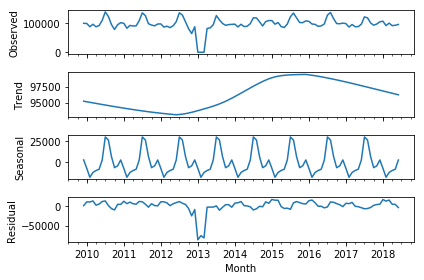

In [84]:
mask = df.Building_Meter == '164.0 - BLD 01_96973681'
series = df.loc[mask, ['Month', 'Imputed_KWH']].set_index('Month')

stl2 = decompose(series, period=12)

stl2.plot();

Example 3 - Number of months is too small - only 12

/Users/feiwang/miniconda3/envs/capstone/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/feiwang/miniconda3/envs/capstone/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


TypeError: Empty 'DataFrame': no numeric data to plot

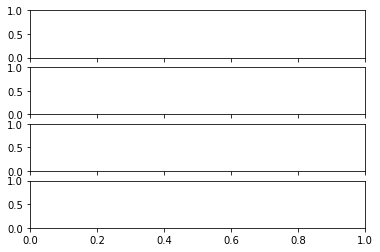

In [66]:
mask = df.Building_Meter == '1.0 - BLD 04_8638820'
series = df.loc[mask, ['Month', 'Imputed_KWH']].set_index('Month')

stl3 = decompose(series, period=12)

stl3.plot();

### sesd package

In [91]:
# R codes

ts = select(filter(df, Building_Meter == '1.0 - BLD 01_7836716'), Month, Imputed_KWH)  
res = AnomalyDetectionTs(ts, max_anoms=0.02, direction='both', plot=TRUE)  
res$plot 

ts = select(filter(df, Building_Meter == '1.0 - BLD 01_7836716'), Month, Imputed_KWH)  
res = AnomalyDetectionTs(ts, max_anoms=0.02, direction='both', plot=TRUE)  
res$plot 

In [ ]:
accounts = unique(df$Building_Meter) 

In [ ]:
anoms <- rep(NA, length(accounts))

for (i in seq(1:5))
{
ts = select(filter(df, Building_Meter == account), Month, Imputed_KWH)  
res = AnomalyDetectionTs(ts, max_anoms=0.02, direction='both', plot=FALSE)  
anoms[i] <- res$anoms 
}

In [95]:
# Python codes

In [96]:
import statsmodels.api as sm

Exampel 1

In [98]:
mask = df.Building_Meter == '165.0 - BLD 03_90327795'
series = df.loc[mask, ['Month', 'Imputed_KWH']].set_index('Month').Imputed_KWH
ts = series.values.ravel()
outliers_indices = sesd.seasonal_esd(ts, seasonality = 12, hybrid=True, max_anomalies=10)
for idx in outliers_indices:
    print ("Anomaly index: {0}, anomaly value: {1}".format(idx, ts[idx]))

Anomaly index: 35, anomaly value: 82710.30303030302
Anomaly index: 80, anomaly value: 222030.0


In [100]:
seasonality = 12
hybrid = True
max_anomalies = 10
alpha = 0.05

ts = np.array(ts)
seasonal = seasonality or int(0.2 * len(ts)) # Seasonality is 20% of the ts if not given.
decomp = sm.tsa.seasonal_decompose(ts, freq=seasonal)
if hybrid:
    mad      = np.median(np.abs(ts - np.median(ts)))
    residual = ts - decomp.seasonal - mad
else:
    residual = ts - decomp.seasonal - np.median(ts)

outliers = sesd.esd(residual, max_anomalies=max_anomalies, alpha=alpha)

seasonal = decomp.seasonal
trend = [np.median(ts) for i in range(len(ts))]
resid = residual
observed = ts

# pd.DataFrame({'observed':ts
#               , 'seasonal':decomp.seasonal
#               , 'median':list([np.median(ts) for i in range(len(ts))])
#               , 'residual':residual
#              })

,median,observed,residual,seasonal
0,146669.037037,151280.000000,148512.058934,-5402.521259
1,146669.037037,151382.857143,148205.956232,-4993.561414
2,146669.037037,136106.798030,147816.780049,-19880.444344
3,146669.037037,145210.950888,147200.189282,-10159.700719
4,146669.037037,135622.152560,144346.015079,-16894.324843
5,146669.037037,138498.574713,142637.183760,-12309.071372
6,146669.037037,161783.666667,152620.653275,992.551067
7,146669.037037,213036.379310,157789.898510,47076.018476
8,146669.037037,192317.330367,142551.989282,41594.878760
9,146669.037037,159626.475508,139109.063933,12346.949250


## Apply G-ESD Test to the residuals

### Example 1

### seasonal_decompose package

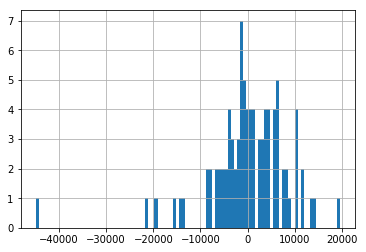

In [34]:
x = result1.resid.Imputed_KWH
x.hist(bins = 100)

Number of outliers:  1
Indices of outliers:  [29]


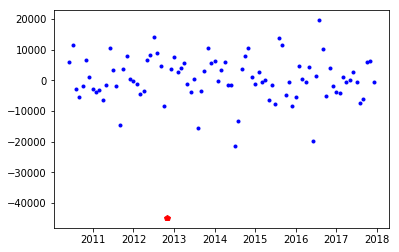

In [35]:
x = x[~np.isnan(x)]

r = pyasl.generalizedESD(x, 5, 0.05, fullOutput=True)

print("Number of outliers: ", r[0])
print("Indices of outliers: ", r[1])
# print("        R      Lambda")
# for i in range(len(r[2])):
#     print("%2d  %8.5f  %8.5f" % ((i+1), r[2][i], r[3][i]))

# Plot the "data"
plt.plot(x, 'b.')
# and mark the outliers.
for i in range(r[0]):
    plt.plot(x.index[r[1][i]], x[r[1][i]], 'rp')
plt.show()

### stldecompose package

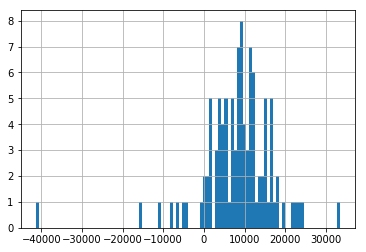

In [36]:
x = stl1.resid.Imputed_KWH
x.hist(bins = 100)

Number of outliers:  3
Indices of outliers:  [35, 80, 55]


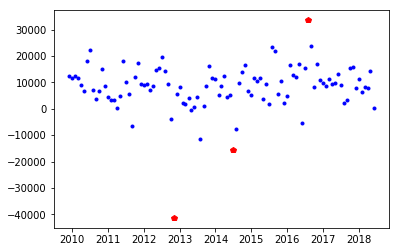

In [32]:
x = x[~np.isnan(x)]

r = pyasl.generalizedESD(x, 3, 0.05, fullOutput=True)

print("Number of outliers: ", r[0])
print("Indices of outliers: ", r[1])
# print("        R      Lambda")
# for i in range(len(r[2])):
#     print("%2d  %8.5f  %8.5f" % ((i+1), r[2][i], r[3][i]))

# Plot the "data"
plt.plot(x, 'b.')
# and mark the outliers.
for i in range(r[0]):
    plt.plot(x.index[r[1][i]], x[r[1][i]], 'rp')
plt.show()

### Example 2

### seasonal_decompose package

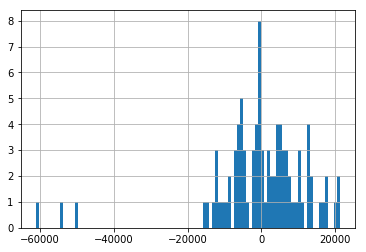

In [40]:
x = result2.resid.Imputed_KWH
x.hist(bins = 100)

Number of outliers:  3
Indices of outliers:  [31, 33, 32]


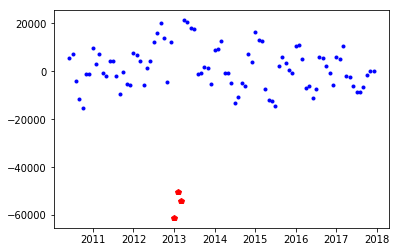

In [41]:
x = x[~np.isnan(x)]

r = pyasl.generalizedESD(x, 5, 0.05, fullOutput=True)

print("Number of outliers: ", r[0])
print("Indices of outliers: ", r[1])
# print("        R      Lambda")
# for i in range(len(r[2])):
#     print("%2d  %8.5f  %8.5f" % ((i+1), r[2][i], r[3][i]))

# Plot the "data"
plt.plot(x, 'b.')
# and mark the outliers.
for i in range(r[0]):
    plt.plot(x.index[r[1][i]], x[r[1][i]], 'rp')
plt.show()

### stldecompose package

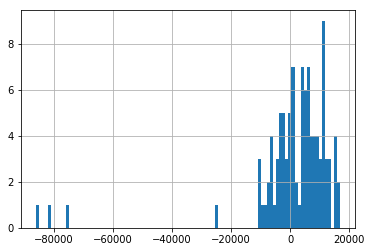

In [42]:
x = stl2.resid.Imputed_KWH
x.hist(bins = 100)

Number of outliers:  3
Indices of outliers:  [37, 39, 38]


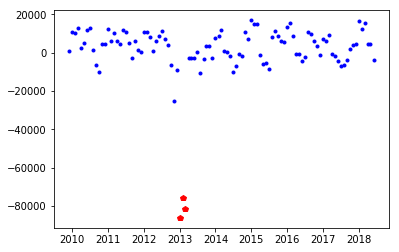

In [44]:
x = x[~np.isnan(x)]

r = pyasl.generalizedESD(x, 3, 0.05, fullOutput=True)

print("Number of outliers: ", r[0])
print("Indices of outliers: ", r[1])
# print("        R      Lambda")
# for i in range(len(r[2])):
#     print("%2d  %8.5f  %8.5f" % ((i+1), r[2][i], r[3][i]))

# Plot the "data"
plt.plot(x, 'b.')
# and mark the outliers.
for i in range(r[0]):
    plt.plot(x.index[r[1][i]], x[r[1][i]], 'rp')
plt.show()